In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import os

from collections import namedtuple


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, fs, frame_duration):
    frame_len = round(frame_duration * fs)
    total_frames = len(signal) // frame_len

    frames = signal[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# plot a signal in continuous time
def plot_continuous(signal, fs, title, ylabel=None):
    t = np.arange(len(signal)) / fs

    plt.plot(t, signal)
    plt.xlabel("Time (s)")
    plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    plt.show()


# plot a signal in both continuous and discrete time in the same plot
def plot_continuous_and_discrete(signal, fs, title, discrete_vlines=None):
    signal_len = len(signal)
    t = np.arange(signal_len) / fs
    n = np.arange(signal_len)

    fig, ax = plt.subplots(2, layout="constrained")

    ax[0].plot(t, signal)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Continuous")
    if discrete_vlines is not None:
        for vline in discrete_vlines:
            ax[0].axvline(vline / fs, color="r")

    ax[1].plot(n, signal)
    ax[1].set_xlabel("n")
    ax[1].set_title("Discrete")
    if discrete_vlines is not None:
        for vline in discrete_vlines:
            ax[1].axvline(vline, color="r")

    fig.suptitle(title)
    plt.show()

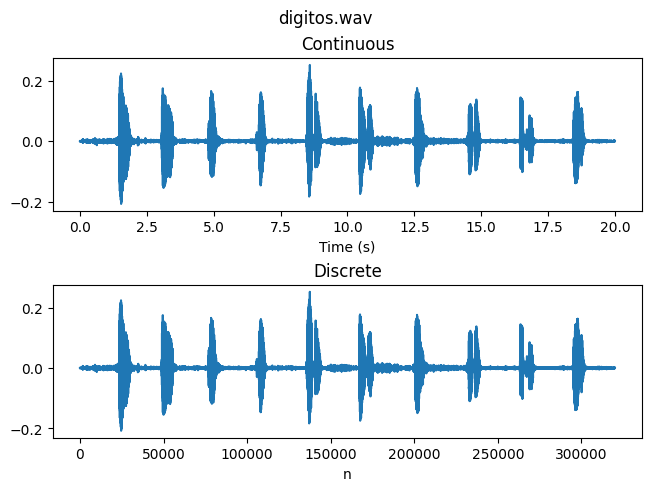

In [61]:
AUDIO_DIR = "audio/"


# Create a named tuple to represent a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])

# get the signal and the sampling frequency
signal_path = os.path.join(AUDIO_DIR, "digitos.wav")
fs, y = wav.read(signal_path)

# normalize the signal
# signals are stored as 16-bit signed integers
y = y / 2**15
signal = Signal(y, fs, os.path.basename(signal_path))

# represent the signal in continuous and discrete time
plot_continuous_and_discrete(signal.y, signal.fs, signal.file)

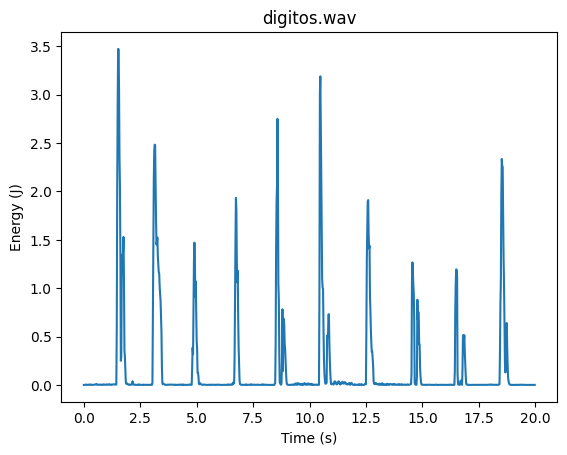

In [62]:
frame_duration = 0.02  # frame duration in seconds
fs = 1 / frame_duration  # sampling frequency

# calculate the energy of the signal in non-overlapping frames
energy_frames = non_overlapping_frames(signal.y, signal.fs, frame_duration)
signal_energy = (energy_frames**2).sum(axis=0)

# represent the energy of the signal in continuous time
plot_continuous(signal_energy, fs, signal.file, "Energy (J)")

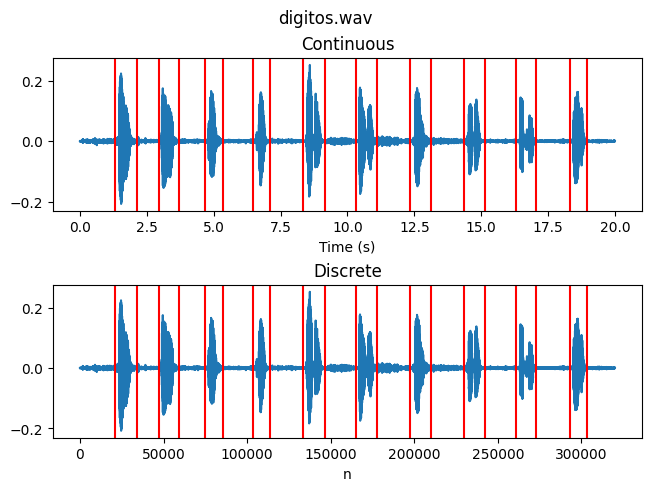

In [63]:
discrete_speech_segments = np.array(
    [
        (21000, 34000),
        (47000, 59000),
        (74500, 85600),
        (103500, 113500),
        (133500, 146500),
        (165000, 177500),
        (197500, 210000),
        (230000, 242000),
        (261000, 273000),
        (293000, 303000),
    ]
)

plot_continuous_and_discrete(
    signal.y, signal.fs, signal.file, discrete_vlines=discrete_speech_segments.flatten()
)

In [64]:
offset = 0.5  # offset in seconds
offset_samples = round(offset * signal.fs)

digit_signals = [
    signal.y[start - offset_samples : end + offset_samples]
    for start, end in discrete_speech_segments
]

# dictionary to store the digits
digits_dic = {
    0: "cero",
    1: "uno",
    2: "dos",
    3: "tres",
    4: "cuatro",
    5: "cinco",
    6: "seis",
    7: "siete",
    8: "ocho",
    9: "nueve",
}

for i, signal in enumerate(digit_signals):
    audio_path = os.path.join(AUDIO_DIR, f"{digits_dic[i]}.wav")
    wav.write(audio_path, 16000, signal)